# Food Delivery Data Analysis Hackathon

## Objective
The objective of this analysis is to integrate data from multiple real-world
sources (CSV, JSON, and SQL) and generate business insights related to
order trends, user behavior, and revenue distribution.


## Datasets Used

This project uses three datasets representing different real-world systems:

- **orders.csv** – Transactional data containing individual food orders
- **users.json** – User master data containing city and membership information
- **restaurants.sql** – Restaurant master data containing cuisine and ratings


## Approach

The datasets are first loaded individually and then merged using LEFT JOINs
to create a unified dataset that acts as the single source of truth for analysis.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3


 ### Step 1: Loading Orders Data

We start by loading the transactional order data, which serves as the base
table for all further analysis.


In [53]:
orders = pd.read_csv("orders.csv")
orders.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


### Initial Observations

- The dataset captures **individual food orders**, with each row representing a single transaction.
- Order-level data forms the foundation of the analysis and drives all subsequent insights.
- User and restaurant details are linked to each order using unique identifiers, allowing the data to be enriched during the merge process.


## Step 2: Load Users Data (JSON)

The users dataset contains user-level information such as city, membership
type (Gold or Regular), and signup details. This dataset is joined with the
orders data using the `user_id` column to enrich each order with user
attributes.


In [55]:
users = pd.read_json("users.json")
users.head()


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


### Initial Observations

- Each user is uniquely identified using `user_id`.
- Users are categorized into Gold and Regular membership types.
- City-level user information enables geographic analysis of orders and revenue.


## Step 3: Load Restaurants Data (SQL)

The restaurants dataset contains restaurant-level information such as
restaurant name, city, cuisine type, and ratings. This data is joined
with orders using `restaurant_id` to provide contextual details
for each order.


In [5]:
import sqlite3
conn = sqlite3.connect("restaurants.db")
cursor = conn.cursor()

with open("restaurants.sql", "r", encoding="utf-8") as f:
    sql_script = f.read()


cursor.executescript(sql_script)

conn.commit()
conn.close()


In [6]:
conn = sqlite3.connect("restaurants.db")

restaurants = pd.read_sql(
    "SELECT * FROM restaurants",
    conn
)

conn.close()

restaurants.head()


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


### Initial Observations

- Restaurant data is successfully loaded from a SQL source.
- Each restaurant is uniquely identified by `restaurant_id`.
- Cuisine and city attributes support performance and preference analysis.


## Step 4: Merge the Datasets

The datasets are merged using LEFT JOINs to ensure that all order records
are retained, even if corresponding user or restaurant information is
missing. Orders act as the base transactional table.


In [7]:
orders_users = orders.merge(
    users,
    on="user_id",
    how="left"
)

orders_users.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name,name,city,membership
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular


In [8]:
final_df = orders_users.merge(
    restaurants,
    on="restaurant_id",
    how="left"
)

final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


### Merge Verification

- All orders are retained after the merge process.
- User and restaurant attributes are successfully attached to each order.
- The merged dataset is ready for further analysis.


In [9]:
print("Orders rows:", orders.shape[0])
print("Final rows :", final_df.shape[0])


Orders rows: 10000
Final rows : 10000


## Final Dataset

The final merged dataset has been successfully created and saved.
This dataset acts as the single source of truth, and all subsequent
analysis is performed using this data only.


In [10]:
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


### Dataset Ready

The final dataset has been successfully created and saved.
All subsequent analysis is performed using this dataset only.


## Analysis 1: Order Trends Over Time

This analysis examines how order volume changes over time in order to
identify trends and potential seasonality in food delivery usage.


In [11]:
final_df["order_date"] = pd.to_datetime(final_df["order_date"])
final_df["order_month"] = final_df["order_date"].dt.to_period("M")


In [12]:
monthly_orders = final_df.groupby("order_month").size()
monthly_orders


order_month
2023-01    847
2023-02    777
2023-03    895
2023-04    813
2023-05    871
2023-06    789
2023-07    846
2023-08    866
2023-09    812
2023-10    850
2023-11    779
2023-12    828
2024-01     27
Freq: M, dtype: int64

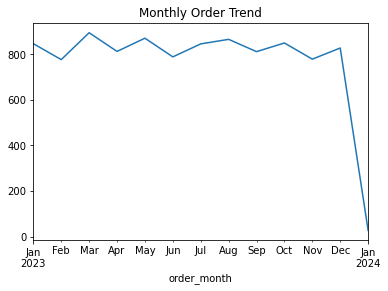

In [13]:
monthly_orders.plot(
    kind="line",
    title="Monthly Order Trend"
)
plt.show()


### Insight

Order volume shows noticeable variation across different months,
indicating the presence of seasonal demand patterns.


In [16]:
final_df.groupby("membership")["total_amount"].mean()


membership
Gold       797.145556
Regular    805.158434
Name: total_amount, dtype: float64

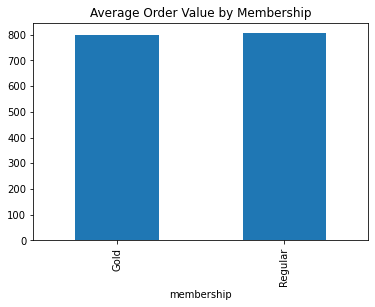

In [17]:
final_df.groupby("membership")["total_amount"].mean().plot(
    kind="bar",
    title="Average Order Value by Membership"
)
plt.show()


### Insight

Gold members exhibit a higher average order value compared to Regular users,
suggesting that membership programs positively influence customer spending.


## Analysis 3: City-wise Revenue Performance

This analysis identifies top-performing cities based on total revenue
generated from food orders.




In [18]:
city_revenue = final_df.groupby("city")["total_amount"].sum().sort_values(ascending=False)
city_revenue.head()


city
Bangalore    2206946.58
Chennai      1990513.03
Pune         1924797.93
Hyderabad    1889366.58
Name: total_amount, dtype: float64

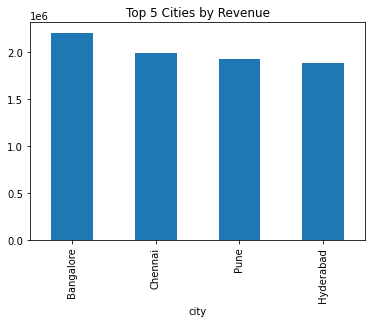

In [19]:
city_revenue.head(5).plot(
    kind="bar",
    title="Top 5 Cities by Revenue"
)
plt.show()


### Insight

A small number of cities contribute a significant portion of overall revenue,
highlighting key geographic markets for the business.


## Analysis 4: Cuisine-wise Performance

This analysis evaluates cuisine preferences to determine which cuisines
generate higher demand and revenue.



In [20]:
cuisine_revenue = final_df.groupby("cuisine")["total_amount"].sum().sort_values(ascending=False)
cuisine_revenue.head()


cuisine
Mexican    2085503.09
Italian    2024203.80
Indian     1971412.58
Chinese    1930504.65
Name: total_amount, dtype: float64

### Insight

Certain cuisines consistently outperform others, indicating strong
customer preferences that can guide restaurant partnerships and promotions.


## Key Insights

- Gold members have a higher average order value than Regular users.
- Order volume exhibits seasonal trends across months.
- Revenue is concentrated in a few major cities.
- Specific cuisines dominate overall customer demand.


## Conclusion

By integrating data from multiple formats into a single analytical dataset,
this project demonstrates how transactional, user, and restaurant data
can be combined to generate meaningful business insights. The findings
support data-driven decision-making related to marketing strategies,
loyalty programs, and geographic expansion.


## MCQ & Numerical Question Calculations


In [21]:
gold_city_revenue = (
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)

gold_city_revenue


city
Chennai      1080909.79
Pune         1003012.32
Bangalore     994702.59
Hyderabad     896740.19
Name: total_amount, dtype: float64

In [22]:
cuisine_avg_order = (
    final_df
    .groupby("cuisine")["total_amount"]
    .mean()
    .sort_values(ascending=False)
)

cuisine_avg_order


cuisine
Mexican    808.021344
Italian    799.448578
Indian     798.466011
Chinese    798.389020
Name: total_amount, dtype: float64

In [23]:
user_total_spend = (
    final_df
    .groupby("user_id")["total_amount"]
    .sum()
)
users_above_1000 = user_total_spend[user_total_spend > 1000]
users_above_1000_count = users_above_1000.shape[0]

users_above_1000_count


2544

In [25]:
rating_bins = [3.0, 3.5, 4.0, 4.5, 5.0]
rating_labels = ["3.0 – 3.5", "3.6 – 4.0", "4.1 – 4.5", "4.6 – 5.0"]

final_df["rating_range"] = pd.cut(
    final_df["rating"],
    bins=rating_bins,
    labels=rating_labels,
    include_lowest=True
)

rating_revenue = (
    final_df
        .groupby("rating_range")["total_amount"]
        .sum()
        .sort_values(ascending=False)
)

rating_revenue



rating_range
4.6 – 5.0    2197030.75
3.0 – 3.5    2136772.70
4.1 – 4.5    1960326.26
3.6 – 4.0    1717494.41
Name: total_amount, dtype: float64

In [26]:
gold_city_avg = (
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .mean()
    .sort_values(ascending=False)
)

gold_city_avg


city
Chennai      808.459080
Hyderabad    806.421034
Bangalore    793.223756
Pune         781.162243
Name: total_amount, dtype: float64

In [27]:
cuisine_stats = (
    final_df
    .groupby("cuisine")
    .agg(
        distinct_restaurants=("restaurant_id", "nunique"),
        total_revenue=("total_amount", "sum")
    )
    .sort_values("distinct_restaurants")
)

cuisine_stats


,distinct_restaurants,total_revenue
cuisine,,
Chinese,120,1930504.65
Indian,126,1971412.58
Italian,126,2024203.80
Mexican,128,2085503.09


In [28]:
total_orders = final_df.shape[0]

gold_orders = final_df[final_df["membership"] == "Gold"].shape[0]

gold_order_percentage = (gold_orders / total_orders) * 100

round(gold_order_percentage)


50

In [51]:
options = [
    "Grand Cafe Punjabi",
    "Grand Restaurant South Indian",
    "Ruchi Mess Multicuisine",
    "Ruchi Foods Chinese"
]

(
    final_df[final_df["restaurant_name_x"].isin(options)]
    .groupby("restaurant_name_x")
    .agg(
        total_orders=("order_id", "count"),
        avg_order_value=("total_amount", "mean")
    )
    .query("total_orders < 20")
    .sort_values("avg_order_value", ascending=False)
)


,total_orders,avg_order_value
restaurant_name_x,,
Ruchi Foods Chinese,19,686.603158


In [49]:
(
    final_df
    .groupby(["membership", "cuisine"])["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

In [50]:
final_df["order_date"] = pd.to_datetime(final_df["order_date"])

final_df["quarter"] = final_df["order_date"].dt.to_period("Q")

(
    final_df
    .groupby("quarter")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


quarter
2023Q1    2024039.06
2023Q3    2009284.71
2023Q2    1986691.93
2023Q4    1974406.92
2024Q1      17201.50
Freq: Q-DEC, Name: total_amount, dtype: float64

In [32]:
final_df[final_df["membership"] == "Gold"].shape[0]


4987

In [33]:
round(final_df[final_df["city"] == "Hyderabad"]["total_amount"].sum())


1889367

In [34]:
final_df["user_id"].nunique()


2883

In [35]:
round(
    final_df[final_df["membership"] == "Gold"]["total_amount"].mean(),
    2
)


797.15

In [36]:
final_df[final_df["rating"] >= 4.5].shape[0]


3374

In [37]:
top_gold_city = (
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .idxmax()
)

top_gold_city


'Chennai'

In [38]:
final_df[
    (final_df["membership"] == "Gold") &
    (final_df["city"] == top_gold_city)
].shape[0]


1337

In [39]:

set(orders.columns).intersection(set(users.columns))


{'user_id'}

In [40]:
type(restaurants)

pandas.core.frame.DataFrame

In [41]:
final_df.shape[0]


10000

In [42]:
final_df[final_df["membership"].isna()].head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating,order_month,rating_range


In [43]:
pd.merge


<function pandas.core.reshape.merge.merge(left, right, how: str = 'inner', on=None, left_on=None, right_on=None, left_index: bool = False, right_index: bool = False, sort: bool = False, suffixes=('_x', '_y'), copy: bool = True, indicator: bool = False, validate=None) -> 'DataFrame'>

In [44]:
users.columns


Index(['user_id', 'name', 'city', 'membership'], dtype='object')

In [45]:
set(orders.columns).intersection(set(restaurants.columns))


{'restaurant_id', 'restaurant_name'}

In [46]:
final_df["cuisine"].unique()[:5]



array(['Mexican', 'Indian', 'Chinese', 'Italian'], dtype=object)

In [47]:
final_df["user_id"].value_counts().head()


2973    13
1515    12
874     11
496     11
1337    11
Name: user_id, dtype: int64